In [1]:
import os
import tensorflow as tf
import numpy as np
import itertools
import matplotlib.pyplot as plt
import gc
from datetime import datetime
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [2]:
input_label = []
output_label = []

In [3]:
a,b = 0,0

ficheiro = open("..\\DatasetTratado\\DatasetTratado\\23-02-2018.csv", "r")

ficheiro.readline()
ficheiro.readline()
ficheiro.readline()

linha = ficheiro.readline()
while(linha != ""):
    linha = linha.split(",")
    out = linha.pop(37)
    if(out == "Benign"): 
        out = 0
        b += 1
    else: 
        out = 1
        a += 1
    output_label.append(out)
    input_label.append(linha)
    linha = ficheiro.readline()
ficheiro.close()
print(str(a) + " " + str(b))

566 1042301


In [4]:
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(input_label)
input_label = scaler.transform(input_label)

In [5]:
input_label = np.array(input_label).reshape(len(input_label), 78, 1)
output_label = np.array(output_label)

In [6]:
input_label, output_label = shuffle(input_label, output_label)

<h2>AutoEncoder</h2>

In [7]:
inp_train,inp_test,out_train,out_test = train_test_split(input_label.reshape(len(input_label), 78), input_label.reshape(len(input_label), 78), test_size=0.2)

In [8]:
input_model = layers.Input(shape = (78,))
enc = layers.Dense(units = 64, activation = "relu", use_bias = True)(input_model)
enc = layers.Dense(units = 36, activation = "relu", use_bias = True)(enc)
enc = layers.Dense(units = 18, activation = "relu")(enc)
dec = layers.Dense(units = 36, activation = "relu", use_bias = True)(enc)
dec = layers.Dense(units = 64, activation = "relu", use_bias = True)(dec)
dec = layers.Dense(units = 78, activation = "relu", use_bias = True)(dec)
auto_encoder = keras.Model(input_model, dec)

In [9]:
encoder = keras.Model(input_model, enc)
decoder_input = layers.Input(shape = (18,))
decoder_layer = auto_encoder.layers[-3](decoder_input)
decoder_layer = auto_encoder.layers[-2](decoder_layer)
decoder_layer = auto_encoder.layers[-1](decoder_layer)
decoder = keras.Model(decoder_input, decoder_layer)

In [10]:
auto_encoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00025), loss = "mean_squared_error", metrics = ['accuracy'])

In [11]:
train = auto_encoder.fit(x = inp_train, y = out_train,validation_split= 0.1, epochs = 10, verbose = 1, shuffle = True)

Epoch 1/10
23465/23465 [==============================] - 29s 1ms/step - loss: 0.0063 - accuracy: 0.7148 - val_loss: 0.0030 - val_accuracy: 0.9378
Epoch 2/10
23465/23465 [==============================] - 26s 1ms/step - loss: 0.0030 - accuracy: 0.8782 - val_loss: 0.0030 - val_accuracy: 0.8580
Epoch 3/10
23465/23465 [==============================] - 23s 981us/step - loss: 0.0030 - accuracy: 0.8808 - val_loss: 0.0030 - val_accuracy: 0.8246
Epoch 4/10
23465/23465 [==============================] - 24s 1ms/step - loss: 0.0030 - accuracy: 0.8779 - val_loss: 0.0030 - val_accuracy: 0.8564
Epoch 5/10
23465/23465 [==============================] - 25s 1ms/step - loss: 0.0029 - accuracy: 0.8792 - val_loss: 0.0029 - val_accuracy: 0.8429
Epoch 6/10
23465/23465 [==============================] - 27s 1ms/step - loss: 0.0029 - accuracy: 0.8821 - val_loss: 0.0029 - val_accuracy: 0.9188
Epoch 7/10
23465/23465 [==============================] - 28s 1ms/step - loss: 0.0025 - accuracy: 0.8728 - val_loss:

In [12]:
predict = auto_encoder.predict(inp_test)

In [13]:
losses = keras.losses.mean_squared_error(out_test, predict).numpy()

In [14]:
total = 0
for loss in losses:
    total += loss
print(total / len(losses))

0.0024433109043952026


<h2>cross validation</h2>

In [15]:
confusion_matrixs = []
roc_curvs = []

In [16]:
input_label = encoder.predict(input_label).reshape(len(input_label), 18, 1)

In [17]:
for i in range(10):
    
    mini = int(len(input_label) * 0.10) * i
    maxi = int((len(input_label) * 0.10) * (i + 1))
    
    inp_train = np.array([*input_label[0: mini],*input_label[maxi:len(input_label)]])
    inp_test = np.array(input_label[mini: maxi])
    out_train = np.array([*output_label[0: mini],*output_label[maxi:len(output_label)]])
    out_test = np.array(output_label[mini:maxi])
    
    model = keras.Sequential([
        layers.Input(shape = (18,1)),
        layers.Conv1D(filters = 16, kernel_size = 3, padding = "same", activation = "relu", use_bias = True),
        layers.MaxPool1D(pool_size = 3),
        layers.Conv1D(filters = 8, kernel_size = 3, padding = "same", activation = "relu", use_bias = True),
        layers.MaxPool1D(pool_size = 3),
        layers.Flatten(),
        layers.Dense(units = 2, activation = "softmax")
    ])
    
    model.compile(optimizer= keras.optimizers.Adam(learning_rate= 0.00025), loss="sparse_categorical_crossentropy", metrics=['accuracy'])
    
    treino = model.fit(x = inp_train, y = out_train, validation_split= 0.1, epochs = 10, shuffle = True,verbose = 0)
    
    res = np.array([np.argmax(resu) for resu in model.predict(inp_test)])
    
    confusion_matrixs.append(confusion_matrix(out_test, res))
    fpr, tpr, _ = roc_curve(out_test,  res)
    auc = roc_auc_score(out_test, res)
    roc_curvs.append([fpr, tpr, auc])
    print(i)

0
1
2
3
4
5
6
7
8
9


<h2>Roc Curves</h2>

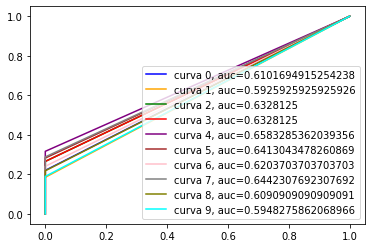

In [18]:
cores = ["blue", "orange", "green", "red", "purple", "brown", "pink", "gray", "olive", "cyan"]
for i in range(10):
    plt.plot(roc_curvs[i][0],roc_curvs[i][1],label="curva " + str(i) + ", auc=" + str(roc_curvs[i][2]), c = cores[i])
plt.legend(loc=4)
plt.show()

In [19]:
total_conv_matrix = [[0,0],[0,0]]
for cov in confusion_matrixs:
    total_conv_matrix[0][0] += cov[0][0] 
    total_conv_matrix[0][1] += cov[0][1]
    total_conv_matrix[1][0] += cov[1][0]
    total_conv_matrix[1][1] += cov[1][1]


In [20]:
def plot_confusion_matrix(cm, classes, normaliza = False, title = "Confusion matrix", cmap = plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normaliza:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")
    
    print(cm)
    
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        color="white" if cm[i,j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1042327       1]
 [    426     140]]


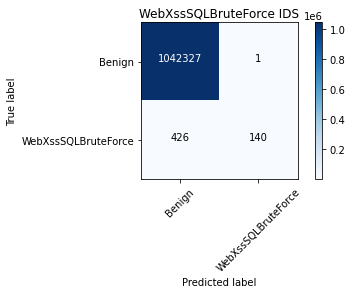

In [21]:
labels = ["Benign", "WebXssSQLBruteForce"]
plot_confusion_matrix(cm = np.array(total_conv_matrix), classes = labels, title = "WebXssSQLBruteForce IDS")